# Stage 2: NLOS Signal Quality Classifier
## Multi-Model Pipeline — Correctable vs Challenging

**Purpose**: Given an NLOS signal (classified by Stage 1), classify its **signal quality** — is it correctable with straightforward ranging error correction, or does it present challenges for Stage 3?

**Mixture labeling from two independent physics measurements:**

| Source | Metric | What it measures |
|--------|--------|------------------|
| **Geometric ground truth** | Bounce dominance | Energy concentration at known bounce position (`bounce_path_idx` from floor plan) |
| **CIR morphology heuristic** | Peak count | Number of prominent peaks in ROI (secondary reflections from floor/ceiling/edges) |

**Combined label (AND logic):**
- **Correctable** (label=0): Bounce dominance ≥ threshold AND ≤ 2 peaks — clean signal, bounce path dominates
- **Challenging** (label=1): Low bounce dominance OR > 2 peaks — dispersed energy or complex multipath

**Why this is NOT circular**: Labels come from (a) geometric ground truth + (b) raw CIR signal processing. Features are 64-dim LNN embeddings (learned temporal dynamics). These are independent.

**Architecture**: Frozen DualCircuit_PI_HLNN encoder → 64-dim LNN embeddings → Random Forest Classifier

**Pipeline**: Stage 1 (LNN → LOS/NLOS) → **Stage 2 (LNN embeddings → RF → signal quality)** → Stage 3 (→ ranging error correction)

In [79]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.signal import find_peaks
from scipy.stats import kurtosis as scipy_kurtosis
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    confusion_matrix, ConfusionMatrixDisplay,
    classification_report, roc_curve, auc
)
import joblib
import os

# ==========================================
# CONFIGURATION
# ==========================================
CONFIG = {
    # ROI alignment (same as Stage 1)
    "search_start": 740,
    "search_end": 890,
    # Peak detection — morphological CIR quality
    "peak_prominence": 0.20,
    "peak_min_distance": 5,
    "dominant_path_max_peaks": 2,  # <= 2 peaks = simple morphology
    # Geometric bounce dominance
    "bounce_search_window": 3,     # ±3 samples around bounce_path_idx
    "dominance_threshold": 0.50,   # >= 50% of ROI energy at bounce = dominant
    # Random Forest
    "n_estimators": 200,
    "max_depth": None,
    "min_samples_split": 5,
    "min_samples_leaf": 2,
    # Split
    "test_ratio": 0.30,
    "seed": 42,
}

np.random.seed(CONFIG["seed"])
print(f"Config: {CONFIG}")
print(f"\nLabel strategy: MIXTURE (geometric × morphological)")
print(f"  Geometric:     bounce dominance >= {CONFIG['dominance_threshold']:.0%} (energy at bounce_path_idx / ROI energy)")
print(f"  Morphological: num_peaks <= {CONFIG['dominant_path_max_peaks']}")
print(f"  Combined:      Correctable (0) = BOTH met; Challenging (1) = either fails")
print(f"  Model input:   64-dim LNN embeddings → RF classifier")

Config: {'search_start': 740, 'search_end': 890, 'peak_prominence': 0.2, 'peak_min_distance': 5, 'dominant_path_max_peaks': 2, 'bounce_search_window': 3, 'dominance_threshold': 0.5, 'n_estimators': 200, 'max_depth': None, 'min_samples_split': 5, 'min_samples_leaf': 2, 'test_ratio': 0.3, 'seed': 42}

Label strategy: MIXTURE (geometric × morphological)
  Geometric:     bounce dominance >= 50% (energy at bounce_path_idx / ROI energy)
  Morphological: num_peaks <= 2
  Combined:      Correctable (0) = BOTH met; Challenging (1) = either fails
  Model input:   64-dim LNN embeddings → RF classifier


---
## Section 2: Data Loading & Mixture Quality Labeling

1. Load NLOS samples from the combined dataset
2. Extract FP_AMPL1/2/3 for encoder conditioning
3. **Mixture quality labeling** from two independent sources:
   - **Geometric**: Compute bounce dominance = energy at known bounce position (`bounce_path_idx`) / total ROI energy
   - **Morphological**: Count prominent peaks in CIR ROI (120 samples from leading edge)
4. **Combined label**: Correctable (0) if BOTH bounce dominates AND few peaks; Challenging (1) otherwise

**Note**: All NLOS data is single-bounce by geometry (TX → wall → RX). The mixture label captures *how tractable* each sample is for Stage 3 correction — combining geometric signal strength with morphological complexity.

In [80]:
# ==========================================
# ROI ALIGNMENT (reused from Stage 1)
# ==========================================
def get_roi_alignment(sig, search_start=CONFIG["search_start"],
                      search_end=CONFIG["search_end"]):
    """Find leading edge by backtracking from peak."""
    region = sig[search_start:search_end]
    if len(region) == 0:
        return np.argmax(sig)

    peak_local = np.argmax(region)
    peak_idx = search_start + peak_local
    peak_val = sig[peak_idx]

    noise_section = sig[:search_start]
    if len(noise_section) > 10:
        noise_mean = np.mean(noise_section)
        noise_std = np.std(noise_section)
        threshold = max(noise_mean + 3 * noise_std, 0.05 * peak_val)
    else:
        threshold = 0.05 * peak_val

    leading_edge = peak_idx
    for i in range(peak_idx, max(search_start - 20, 0), -1):
        if sig[i] < threshold:
            leading_edge = i + 1
            break

    return leading_edge


# ==========================================
# COUNT PEAKS IN CIR ROI (morphological)
# ==========================================
def count_peaks(sig, leading_edge, config=CONFIG):
    """Count prominent peaks in CIR ROI (120 samples from leading edge)."""
    roi_start = max(0, leading_edge - 5)
    roi_end = min(len(sig), leading_edge + 120)
    roi = sig[roi_start:roi_end]
    if len(roi) == 0 or np.max(roi) == 0:
        return 0
    roi_norm = roi / np.max(roi)
    peaks, _ = find_peaks(
        roi_norm,
        prominence=config["peak_prominence"],
        distance=config["peak_min_distance"]
    )
    return len(peaks)


# ==========================================
# GEOMETRIC BOUNCE DOMINANCE
# ==========================================
def compute_bounce_dominance(sig, leading_edge, bounce_path_idx,
                              window=CONFIG["bounce_search_window"]):
    """
    Fraction of ROI energy concentrated at the geometric bounce position.
    Uses bounce_path_idx (known from TX->reflector->RX floor-plan geometry).

    bounce_dominance = energy_at_bounce_window / energy_in_full_ROI
    High = clean signal dominated by expected bounce path
    Low  = significant multipath contamination dispersing energy
    """
    roi_start = max(0, leading_edge - 5)
    roi_end = min(len(sig), leading_edge + 120)

    roi_energy = np.sum(sig[roi_start:roi_end] ** 2)
    if roi_energy < 1e-10:
        return 0.0

    bounce_idx = int(round(bounce_path_idx))
    b_start = max(roi_start, bounce_idx - window)
    b_end = min(roi_end, bounce_idx + window + 1)

    if b_start >= b_end:
        return 0.0

    bounce_energy = np.sum(sig[b_start:b_end] ** 2)
    return bounce_energy / roi_energy


# ==========================================
# LOAD NLOS DATA + MIXTURE QUALITY LABELS
# ==========================================
def load_nlos_features(filepath="../dataset/channels/combined_uwb_dataset.csv"):
    """
    Load NLOS samples and compute mixture quality labels.
    Combines geometric bounce dominance + morphological peak count.
    """
    print(f"Loading: {filepath}")
    df = pd.read_csv(filepath)

    # Filter NLOS only
    nlos_df = df[df["Label"] == 1].reset_index(drop=True)
    print(f"  Total samples: {len(df)}, NLOS samples: {len(nlos_df)}")

    cir_cols = sorted(
        [c for c in df.columns if c.startswith('CIR')],
        key=lambda x: int(x.replace('CIR', ''))
    )

    raw_sigs = []
    leading_edges = []
    fp_features = []
    num_peaks_list = []
    bounce_dom_list = []

    for idx, row in nlos_df.iterrows():
        sig = pd.to_numeric(row[cir_cols], errors='coerce').fillna(0).astype(float).values

        # RXPACC normalization
        rxpacc_col = 'RXPACC' if 'RXPACC' in row.index else 'RX_PACC'
        rxpacc = float(row.get(rxpacc_col, 128.0))
        if rxpacc > 0:
            sig = sig / rxpacc

        # Extract FP_AMPL1/2/3 (same normalization as Stage 1)
        f1 = float(row.get('FP_AMPL1', 0)) / max(rxpacc, 1) / 64.0
        f2 = float(row.get('FP_AMPL2', 0)) / max(rxpacc, 1) / 64.0
        f3 = float(row.get('FP_AMPL3', 0)) / max(rxpacc, 1) / 64.0
        fp_features.append([f1, f2, f3])

        le = get_roi_alignment(sig)
        raw_sigs.append(sig)
        leading_edges.append(le)

        # Morphological: peak count
        num_peaks_list.append(count_peaks(sig, le))

        # Geometric: bounce dominance (energy at known bounce position / ROI energy)
        bpi = float(row.get('bounce_path_idx', np.nan))
        if np.isnan(bpi):
            bounce_dom_list.append(0.0)
        else:
            bounce_dom_list.append(compute_bounce_dominance(sig, le, bpi))

    fp_array = np.array(fp_features, dtype=np.float32)
    num_peaks = np.array(num_peaks_list, dtype=int)
    bounce_dominance = np.array(bounce_dom_list, dtype=float)

    # ── Mixture label: geometric × morphological ──
    peak_thresh = CONFIG["dominant_path_max_peaks"]
    dom_thresh = CONFIG["dominance_threshold"]

    is_bounce_dominant = bounce_dominance >= dom_thresh
    is_morphology_simple = num_peaks <= peak_thresh

    # Correctable (0): BOTH conditions met; Challenging (1): either fails
    quality_labels = np.where(is_bounce_dominant & is_morphology_simple, 0, 1).astype(int)

    n_correctable = int(np.sum(quality_labels == 0))
    n_challenging = int(np.sum(quality_labels == 1))

    print(f"\n  Mixture quality labeling:")
    print(f"    Geometric:     bounce dominance >= {dom_thresh:.2f}")
    print(f"    Morphological: num_peaks <= {peak_thresh}")
    print(f"    {'─' * 45}")
    print(f"    Bounce dominant (>={dom_thresh:.0%}):   {int(np.sum(is_bounce_dominant))} "
          f"({100*np.mean(is_bounce_dominant):.1f}%)")
    print(f"    Simple morphology (≤{peak_thresh} peaks): {int(np.sum(is_morphology_simple))} "
          f"({100*np.mean(is_morphology_simple):.1f}%)")
    print(f"    {'─' * 45}")
    print(f"    Correctable (BOTH met):     {n_correctable} ({100*n_correctable/len(quality_labels):.1f}%)")
    print(f"    Challenging (either fails): {n_challenging} ({100*n_challenging/len(quality_labels):.1f}%)")
    print(f"    {'─' * 45}")
    print(f"    Bounce dominance stats — mean: {bounce_dominance.mean():.3f}, "
          f"min: {bounce_dominance.min():.3f}, max: {bounce_dominance.max():.3f}")
    print(f"    Num_Peaks stats — mean: {num_peaks.mean():.2f}, "
          f"min: {num_peaks.min()}, max: {num_peaks.max()}")
    print(f"  FP_AMPL shape: {fp_array.shape}")

    return (np.array(raw_sigs), np.array(leading_edges), nlos_df,
            fp_array, quality_labels, num_peaks, bounce_dominance)


raw_sigs, leading_edges, nlos_df, fp_ampl_features, quality_labels, num_peaks, bounce_dominance = load_nlos_features()

Loading: ../dataset/channels/combined_uwb_dataset.csv
  Total samples: 3600, NLOS samples: 1800

  Mixture quality labeling:
    Geometric:     bounce dominance >= 0.50
    Morphological: num_peaks <= 2
    ─────────────────────────────────────────────
    Bounce dominant (>=50%):   528 (29.3%)
    Simple morphology (≤2 peaks): 851 (47.3%)
    ─────────────────────────────────────────────
    Correctable (BOTH met):     479 (26.6%)
    Challenging (either fails): 1321 (73.4%)
    ─────────────────────────────────────────────
    Bounce dominance stats — mean: 0.355, min: 0.000, max: 0.804
    Num_Peaks stats — mean: 4.03, min: 1, max: 12
  FP_AMPL shape: (1800, 3)


---
## Section 2b: Mixture Quality Labeling — Geometric × Morphological

Two independent measurements determine signal quality:

**1. Geometric bounce dominance** (from `bounce_path_idx`):
- The dataset provides `bounce_path_idx`: the CIR index where the single-bounce path arrives, computed from the known TX→reflector→RX geometry (floor plan)
- Bounce dominance = energy in ±3 window around `bounce_path_idx` / total ROI energy
- High dominance → most signal energy is at the expected bounce position (clean signal)
- Low dominance → significant energy elsewhere in the ROI (multipath contamination)

**2. CIR morphological complexity** (from peak counting):
- Count prominent peaks in ROI using scipy `find_peaks` (prominence ≥ 0.20, min distance = 5)
- Few peaks (≤ 2) → simple propagation environment
- Many peaks (> 2) → complex multipath from floor/ceiling/edge reflections

**Combined label (AND logic):**
- **Correctable** (0): dominance ≥ threshold AND ≤ 2 peaks
- **Challenging** (1): dominance < threshold OR > 2 peaks

This captures cases that either metric alone would miss:
- Many tiny peaks but bounce still dominates energy → *Challenging* (complex morphology despite strong bounce)
- Few peaks but energy dispersed away from bounce → *Challenging* (simple morphology but poor geometric consistency)

Mixture quality labeling:
  Geometric:     bounce dominance >= 0.50
  Morphological: num_peaks <= 2
  Correctable: 479 (26.6%)
  Challenging: 1321 (73.4%)


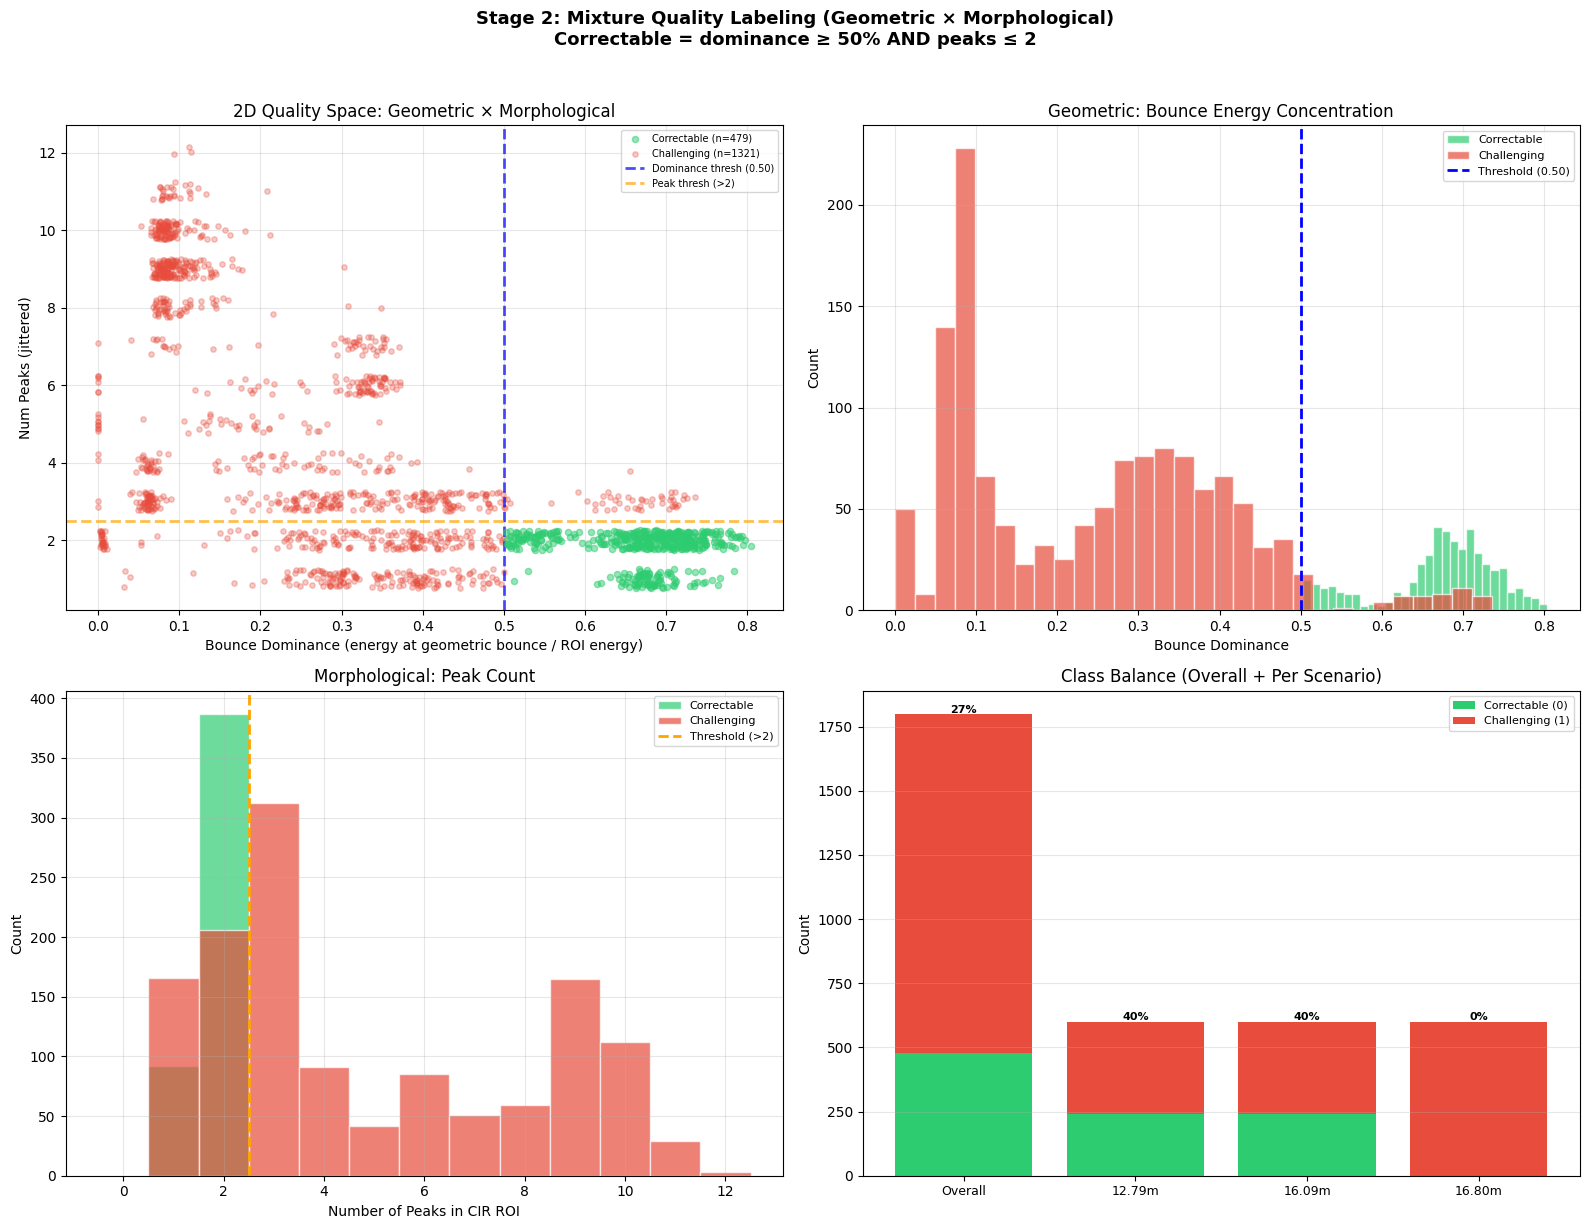


2×2 Contingency Table:
                               |       Few peaks (≤2) |      Many peaks (>2)
───────────────────────────────┼──────────────────────┼─────────────────────
        High dominance (≥0.50) |     Correctable: 479 |      Challenging: 49
         Low dominance (<0.50) |     Challenging: 372 |     Challenging: 900


In [81]:
# ==========================================
# MIXTURE QUALITY LABELING VISUALIZATION
# ==========================================
import re

peak_thresh = CONFIG["dominant_path_max_peaks"]
dom_thresh = CONFIG["dominance_threshold"]
n_correctable = int(np.sum(quality_labels == 0))
n_challenging = int(np.sum(quality_labels == 1))

print(f"Mixture quality labeling:")
print(f"  Geometric:     bounce dominance >= {dom_thresh:.2f}")
print(f"  Morphological: num_peaks <= {peak_thresh}")
print(f"  Correctable: {n_correctable} ({100*n_correctable/len(quality_labels):.1f}%)")
print(f"  Challenging: {n_challenging} ({100*n_challenging/len(quality_labels):.1f}%)")

fig, axs = plt.subplots(2, 2, figsize=(16, 12))
plt.subplots_adjust(hspace=0.35, wspace=0.3)

correctable_mask = quality_labels == 0
challenging_mask = quality_labels == 1

# ─── 1. 2D scatter: Bounce Dominance vs Num_Peaks (quality space) ───
ax = axs[0, 0]
jitter_peaks = num_peaks + np.random.uniform(-0.25, 0.25, size=len(num_peaks))
ax.scatter(bounce_dominance[correctable_mask], jitter_peaks[correctable_mask],
           c='#2ecc71', alpha=0.5, s=20, label=f'Correctable (n={n_correctable})', zorder=3)
ax.scatter(bounce_dominance[challenging_mask], jitter_peaks[challenging_mask],
           c='#e74c3c', alpha=0.3, s=15, label=f'Challenging (n={n_challenging})', zorder=2)
ax.axvline(dom_thresh, color='blue', ls='--', lw=2, alpha=0.7,
           label=f'Dominance thresh ({dom_thresh:.2f})')
ax.axhline(peak_thresh + 0.5, color='orange', ls='--', lw=2, alpha=0.7,
           label=f'Peak thresh (>{peak_thresh})')
ax.set_xlabel('Bounce Dominance (energy at geometric bounce / ROI energy)')
ax.set_ylabel('Num Peaks (jittered)')
ax.set_title('2D Quality Space: Geometric × Morphological')
ax.legend(fontsize=7, loc='upper right')
ax.grid(True, alpha=0.3)

# ─── 2. Bounce Dominance histogram ───
ax = axs[0, 1]
ax.hist(bounce_dominance[correctable_mask], bins=30, color='#2ecc71', alpha=0.7,
        label='Correctable', edgecolor='white')
ax.hist(bounce_dominance[challenging_mask], bins=30, color='#e74c3c', alpha=0.7,
        label='Challenging', edgecolor='white')
ax.axvline(dom_thresh, color='blue', ls='--', lw=2, label=f'Threshold ({dom_thresh:.2f})')
ax.set_xlabel('Bounce Dominance')
ax.set_ylabel('Count')
ax.set_title('Geometric: Bounce Energy Concentration')
ax.legend(fontsize=8)
ax.grid(True, alpha=0.3)

# ─── 3. Num Peaks histogram ───
ax = axs[1, 0]
bins = np.arange(0, num_peaks.max() + 2) - 0.5
ax.hist(num_peaks[correctable_mask], bins=bins, color='#2ecc71', alpha=0.7,
        label='Correctable', edgecolor='white')
ax.hist(num_peaks[challenging_mask], bins=bins, color='#e74c3c', alpha=0.7,
        label='Challenging', edgecolor='white')
ax.axvline(peak_thresh + 0.5, color='orange', ls='--', lw=2,
           label=f'Threshold (>{peak_thresh})')
ax.set_xlabel('Number of Peaks in CIR ROI')
ax.set_ylabel('Count')
ax.set_title('Morphological: Peak Count')
ax.legend(fontsize=8)
ax.grid(True, alpha=0.3)

# ─── 4. Class balance: overall + per scenario ───
ax = axs[1, 1]
source_files = nlos_df['Source_File'].values
groups = []
for sf in source_files:
    match = re.search(r'([\d.]+)m_nlos', str(sf))
    groups.append(match.group(1) + 'm' if match else 'unknown')
groups = np.array(groups)
unique_groups = sorted(set(groups))

x_pos = np.arange(len(unique_groups) + 1)
labels_bar = ['Overall'] + unique_groups
correctable_counts = [n_correctable]
challenging_counts = [n_challenging]
for g in unique_groups:
    mask = groups == g
    correctable_counts.append(int(np.sum(quality_labels[mask] == 0)))
    challenging_counts.append(int(np.sum(quality_labels[mask] == 1)))

ax.bar(x_pos, correctable_counts, color='#2ecc71', label='Correctable (0)')
ax.bar(x_pos, challenging_counts, bottom=correctable_counts,
       color='#e74c3c', label='Challenging (1)')
ax.set_xticks(x_pos)
ax.set_xticklabels(labels_bar, fontsize=9)
ax.set_ylabel('Count')
ax.set_title('Class Balance (Overall + Per Scenario)')
ax.legend(fontsize=8)
ax.grid(True, alpha=0.3, axis='y')

for i in range(len(x_pos)):
    total = correctable_counts[i] + challenging_counts[i]
    pct = 100 * correctable_counts[i] / total if total > 0 else 0
    ax.text(x_pos[i], total + 5, f'{pct:.0f}%', ha='center', fontsize=8, fontweight='bold')

plt.suptitle(f'Stage 2: Mixture Quality Labeling (Geometric × Morphological)\n'
             f'Correctable = dominance ≥ {dom_thresh:.0%} AND peaks ≤ {peak_thresh}',
             fontsize=13, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

# ─── 2×2 Contingency Table ───
bd_high = bounce_dominance >= dom_thresh
bd_low = bounce_dominance < dom_thresh
pk_low = num_peaks <= peak_thresh
pk_high = num_peaks > peak_thresh

print(f"\n2×2 Contingency Table:")
print(f"{'':>30} | {'Few peaks (≤' + str(peak_thresh) + ')':>20} | {'Many peaks (>' + str(peak_thresh) + ')':>20}")
print(f"{'─'*30}─┼─{'─'*20}─┼─{'─'*20}")
print(f"{'High dominance (≥' + f'{dom_thresh:.2f}' + ')':>30} | "
      f"{'Correctable: ' + str(int(np.sum(bd_high & pk_low))):>20} | "
      f"{'Challenging: ' + str(int(np.sum(bd_high & pk_high))):>20}")
print(f"{'Low dominance (<' + f'{dom_thresh:.2f}' + ')':>30} | "
      f"{'Challenging: ' + str(int(np.sum(bd_low & pk_low))):>20} | "
      f"{'Challenging: ' + str(int(np.sum(bd_low & pk_high))):>20}")

---
## Section 3: Shared LNN Encoder — Embedding Extraction

The Stage 1 **DualCircuit_PI_HLNN** processes raw CIR sequences through dual ODE-based liquid circuits with FP_AMPL conditioning. We **freeze** the trained encoder and extract **64-dim LNN embeddings** (attention-pooled hidden states) for each NLOS sample.

These embeddings are passed to Stage 3 for ranging error correction. The dual-circuit LNN captures rich temporal dynamics from the CIR waveform.

**Key**: The encoder uses FP_AMPL1/2/3 conditioning — hardware first-path amplitudes seed the circuit initial states (scaled by 0.1), making the embeddings FP-informed.

In [82]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class PILiquidCell(nn.Module):
    """
    Conductance-based LTC cell (Hasani et al. 2020).
    - Recurrent synapses: full conductance with reversal potentials
    - Sensory synapses: gated additive input (direct injection)
    - Softplus on conductances only (gleak, cm, w, sensory_w)
    - ODE solved via semi-implicit Euler
    - Hidden state clamped to [-1, 1] each sub-step (prevents divergence)
    """
    def __init__(self, input_size, hidden_size, ode_unfolds=6):
        super().__init__()
        self.hidden_size = hidden_size
        self.input_size = input_size
        self.ode_unfolds = ode_unfolds

        self.gleak = nn.Parameter(torch.empty(hidden_size).uniform_(0.001, 1.0))
        self.vleak = nn.Parameter(torch.empty(hidden_size).uniform_(-0.2, 0.2))
        self.cm    = nn.Parameter(torch.empty(hidden_size).uniform_(0.4, 0.6))

        self.w     = nn.Parameter(torch.empty(hidden_size, hidden_size).uniform_(0.001, 1.0))
        self.erev  = nn.Parameter(torch.empty(hidden_size, hidden_size).uniform_(-0.2, 0.2))
        self.mu    = nn.Parameter(torch.empty(hidden_size, hidden_size).uniform_(0.3, 0.8))
        self.sigma = nn.Parameter(torch.empty(hidden_size, hidden_size).uniform_(3, 8))

        self.sensory_w     = nn.Parameter(torch.empty(input_size, hidden_size).uniform_(0.001, 1.0))
        self.sensory_mu    = nn.Parameter(torch.empty(input_size, hidden_size).uniform_(0.3, 0.8))
        self.sensory_sigma = nn.Parameter(torch.empty(input_size, hidden_size).uniform_(3, 8))

    def forward(self, x_t, h_prev, dt=1.0):
        gleak     = F.softplus(self.gleak)
        cm        = F.softplus(self.cm)
        w         = F.softplus(self.w)
        sensory_w = F.softplus(self.sensory_w)

        sensory_gate    = torch.sigmoid(self.sensory_sigma * (x_t.unsqueeze(-1) - self.sensory_mu))
        sensory_current = (sensory_w * sensory_gate * x_t.unsqueeze(-1)).sum(dim=1)

        cm_t = cm / (dt / self.ode_unfolds)
        v    = h_prev

        for _ in range(self.ode_unfolds):
            recurrent_gate = torch.sigmoid(self.sigma.unsqueeze(0) * (v.unsqueeze(2) - self.mu.unsqueeze(0)))
            w_gate = w.unsqueeze(0) * recurrent_gate
            w_num  = (w_gate * self.erev.unsqueeze(0)).sum(dim=1)
            w_den  = w_gate.sum(dim=1)
            numerator   = cm_t * v + gleak * self.vleak + w_num + sensory_current
            denominator = cm_t + gleak + w_den + 1e-8
            v = numerator / denominator
            v = torch.clamp(v, -1.0, 1.0)

        tau = cm / (gleak + w_den + 1e-8)
        return v, tau


class DualCircuit_PI_HLNN(nn.Module):
    """
    Dual-circuit PI-HLNN with cross-circuit communication + FP_AMPL conditioning.
    Must match Stage 1 architecture exactly for weight loading.
    """
    def __init__(self, input_size=1, hidden_size=32, dropout=0.4, ode_unfolds=6):
        super().__init__()
        self.hidden_size = hidden_size

        self.cell_los  = PILiquidCell(input_size, hidden_size, ode_unfolds)
        self.cell_nlos = PILiquidCell(input_size, hidden_size, ode_unfolds)

        self.fp_to_los_init  = nn.Linear(3, hidden_size)
        self.fp_to_nlos_init = nn.Linear(3, hidden_size)

        self.P_nlos2los = nn.Linear(hidden_size, hidden_size, bias=False)
        self.P_los2nlos = nn.Linear(hidden_size, hidden_size, bias=False)

        self.gate_los  = nn.Linear(hidden_size * 2, hidden_size)
        self.gate_nlos = nn.Linear(hidden_size * 2, hidden_size)

        self.los_attn  = nn.Linear(hidden_size, 1)
        self.nlos_attn = nn.Linear(hidden_size, 1)

        self.classifier = nn.Sequential(
            nn.Linear(hidden_size * 2, hidden_size),
            nn.SiLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_size, 1),
            nn.Sigmoid()
        )

    def _run_circuits(self, x_seq, fp_features=None):
        batch_size, seq_len, _ = x_seq.size()

        if fp_features is not None:
            h_los  = 0.1 * torch.tanh(self.fp_to_los_init(fp_features))
            h_nlos = 0.1 * torch.tanh(self.fp_to_nlos_init(fp_features))
        else:
            h_los  = torch.zeros(batch_size, self.hidden_size, device=x_seq.device)
            h_nlos = torch.zeros(batch_size, self.hidden_size, device=x_seq.device)

        los_states, nlos_states = [], []
        tau_los_sum  = torch.zeros_like(h_los)
        tau_nlos_sum = torch.zeros_like(h_nlos)
        tau_los_hist_list, tau_nlos_hist_list = [], []

        for t in range(seq_len):
            x_t = x_seq[:, t, :]
            proj_nlos_to_los = self.P_nlos2los(h_nlos)
            proj_los_to_nlos = self.P_los2nlos(h_los)
            g_los  = torch.sigmoid(self.gate_los( torch.cat([h_los,  proj_nlos_to_los], dim=1)))
            g_nlos = torch.sigmoid(self.gate_nlos(torch.cat([h_nlos, proj_los_to_nlos], dim=1)))
            h_los_in  = h_los  + g_los  * proj_nlos_to_los
            h_nlos_in = h_nlos + g_nlos * proj_los_to_nlos
            h_los,  tau_los  = self.cell_los( x_t, h_los_in)
            h_nlos, tau_nlos = self.cell_nlos(x_t, h_nlos_in)
            los_states.append(h_los.unsqueeze(1))
            nlos_states.append(h_nlos.unsqueeze(1))
            tau_los_sum  += tau_los
            tau_nlos_sum += tau_nlos
            tau_los_hist_list.append(tau_los.unsqueeze(1))
            tau_nlos_hist_list.append(tau_nlos.unsqueeze(1))

        los_all  = torch.cat(los_states,  dim=1)
        nlos_all = torch.cat(nlos_states, dim=1)
        tau_los_mean  = tau_los_sum  / seq_len
        tau_nlos_mean = tau_nlos_sum / seq_len
        tau_los_hist  = torch.cat(tau_los_hist_list,  dim=1)
        tau_nlos_hist = torch.cat(tau_nlos_hist_list, dim=1)
        return los_all, nlos_all, tau_los_hist, tau_nlos_hist, tau_los_mean, tau_nlos_mean

    def _pool_and_fuse(self, los_all, nlos_all):
        los_w  = F.softmax(self.los_attn(los_all).squeeze(-1),   dim=1).unsqueeze(-1)
        nlos_w = F.softmax(self.nlos_attn(nlos_all).squeeze(-1), dim=1).unsqueeze(-1)
        h_los_pooled  = (los_all  * los_w).sum(dim=1)
        h_nlos_pooled = (nlos_all * nlos_w).sum(dim=1)
        return torch.cat([h_los_pooled, h_nlos_pooled], dim=1)

    def forward(self, x_seq, fp_features=None, return_dynamics=False):
        los_all, nlos_all, tau_los_hist, tau_nlos_hist, tau_los_mean, tau_nlos_mean = \
            self._run_circuits(x_seq, fp_features=fp_features)
        h_fused = self._pool_and_fuse(los_all, nlos_all)
        pred = self.classifier(h_fused)
        if return_dynamics:
            return pred, los_all, nlos_all, tau_los_hist, tau_nlos_hist, tau_los_mean, tau_nlos_mean
        return pred, tau_los_mean, tau_nlos_mean

    def embed(self, x_seq, fp_features=None):
        """Return 64-dim fused embedding for Stage 2/3."""
        los_all, nlos_all, _, _, _, _ = self._run_circuits(x_seq, fp_features=fp_features)
        return self._pool_and_fuse(los_all, nlos_all)


print(f"DualCircuit_PI_HLNN defined: {sum(p.numel() for p in DualCircuit_PI_HLNN().parameters()):,} params")
print(f"  Embedding dim: 64 (2 x 32)")
print(f"  FP_AMPL conditioning: enabled (scale=0.1)")

DualCircuit_PI_HLNN defined: 17,219 params
  Embedding dim: 64 (2 x 32)
  FP_AMPL conditioning: enabled (scale=0.1)


In [83]:
# ==========================================
# LOAD FROZEN STAGE 1 ENCODER & EXTRACT EMBEDDINGS
# ==========================================
# Stage 1 config (must match training exactly)
STAGE1_CONFIG = {
    'pre_crop': 10, 'post_crop': 50, 'total_len': 60,
    'search_start': 740, 'search_end': 890,
    'hidden_size': 32, 'input_size': 1, 'dropout': 0.2, 'ode_unfolds': 6,
}

EMBEDDING_DIM = STAGE1_CONFIG['hidden_size'] * 2  # 64 (2 circuits x 32)
EMBEDDING_NAMES = [f'LNN_h{i}' for i in range(EMBEDDING_DIM)]

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


def preprocess_cir_for_lnn(sig, leading_edge):
    """Convert a single RXPACC-normalized CIR + leading edge to 60-sample window."""
    PRE = STAGE1_CONFIG['pre_crop']
    TOTAL = STAGE1_CONFIG['total_len']
    start = max(0, leading_edge - PRE)
    end = start + TOTAL
    if end > len(sig):
        end = len(sig)
        start = max(0, end - TOTAL)
    crop = sig[start:end]
    if len(crop) < TOTAL:
        crop = np.pad(crop, (0, TOTAL - len(crop)), mode='constant')
    local_min, local_max = np.min(crop), np.max(crop)
    rng = local_max - local_min
    crop = (crop - local_min) / rng if rng > 0 else np.zeros(TOTAL)
    return crop


# Load frozen Stage 1 encoder (DualCircuit_PI_HLNN)
lnn_encoder = DualCircuit_PI_HLNN(
    input_size=STAGE1_CONFIG['input_size'],
    hidden_size=STAGE1_CONFIG['hidden_size'],
    dropout=STAGE1_CONFIG['dropout'],
    ode_unfolds=STAGE1_CONFIG['ode_unfolds'],
).to(device)

checkpoint_path = 'stage1_pi_hlnn_best.pt'
lnn_encoder.load_state_dict(torch.load(checkpoint_path, map_location=device, weights_only=True))
lnn_encoder.eval()
for param in lnn_encoder.parameters():
    param.requires_grad = False

print(f"Loaded frozen Stage 1 encoder from {checkpoint_path}")
print(f"  Architecture: DualCircuit_PI_HLNN (hidden={STAGE1_CONFIG['hidden_size']} per circuit)")
print(f"  Device: {device}")
print(f"  Parameters: {sum(p.numel() for p in lnn_encoder.parameters()):,} (all frozen)")
print(f"  Embedding dim: {EMBEDDING_DIM} (attention-pooled, 2 x {STAGE1_CONFIG['hidden_size']})")
print(f"  FP_AMPL conditioning: enabled")

# Extract 64-dim LNN embeddings for all NLOS samples
print(f"\nExtracting {EMBEDDING_DIM}-dim embeddings for {len(nlos_df)} NLOS samples...")

cir_sequences = []
for i in range(len(raw_sigs)):
    crop = preprocess_cir_for_lnn(raw_sigs[i], leading_edges[i])
    cir_sequences.append(crop)

cir_tensor = torch.tensor(
    np.array(cir_sequences).reshape(-1, STAGE1_CONFIG['total_len'], 1),
    dtype=torch.float32
).to(device)

fp_tensor = torch.tensor(fp_ampl_features, dtype=torch.float32).to(device)

all_embeddings = []
with torch.no_grad():
    for i in range(0, len(cir_tensor), 256):
        batch_cir = cir_tensor[i:i+256]
        batch_fp  = fp_tensor[i:i+256]
        emb = lnn_encoder.embed(batch_cir, fp_features=batch_fp)  # (batch, 64)
        all_embeddings.append(emb.cpu().numpy())

embeddings = np.vstack(all_embeddings)

print(f"  Embeddings shape: {embeddings.shape}")
print(f"  Feature names: {EMBEDDING_NAMES[:3]} ... {EMBEDDING_NAMES[-1]}")
print(f"  Embedding stats — mean: {embeddings.mean():.4f}, std: {embeddings.std():.4f}")
print(f"\nReady for Random Forest training on {EMBEDDING_DIM}-dim LNN embeddings.")

Loaded frozen Stage 1 encoder from stage1_pi_hlnn_best.pt
  Architecture: DualCircuit_PI_HLNN (hidden=32 per circuit)
  Device: cuda
  Parameters: 17,219 (all frozen)
  Embedding dim: 64 (attention-pooled, 2 x 32)
  FP_AMPL conditioning: enabled

Extracting 64-dim embeddings for 1800 NLOS samples...
  Embeddings shape: (1800, 64)
  Feature names: ['LNN_h0', 'LNN_h1', 'LNN_h2'] ... LNN_h63
  Embedding stats — mean: 0.0696, std: 0.0973

Ready for Random Forest training on 64-dim LNN embeddings.


---
## Section 4: CIR Waveform Examples

Compare **Correctable** (clean, bounce-dominated, few peaks) vs **Challenging** (dispersed energy or complex morphology) CIR waveforms.

Red vertical line marks the geometric bounce position (`bounce_path_idx`). Shaded red region shows the ±3 search window used for bounce dominance computation.

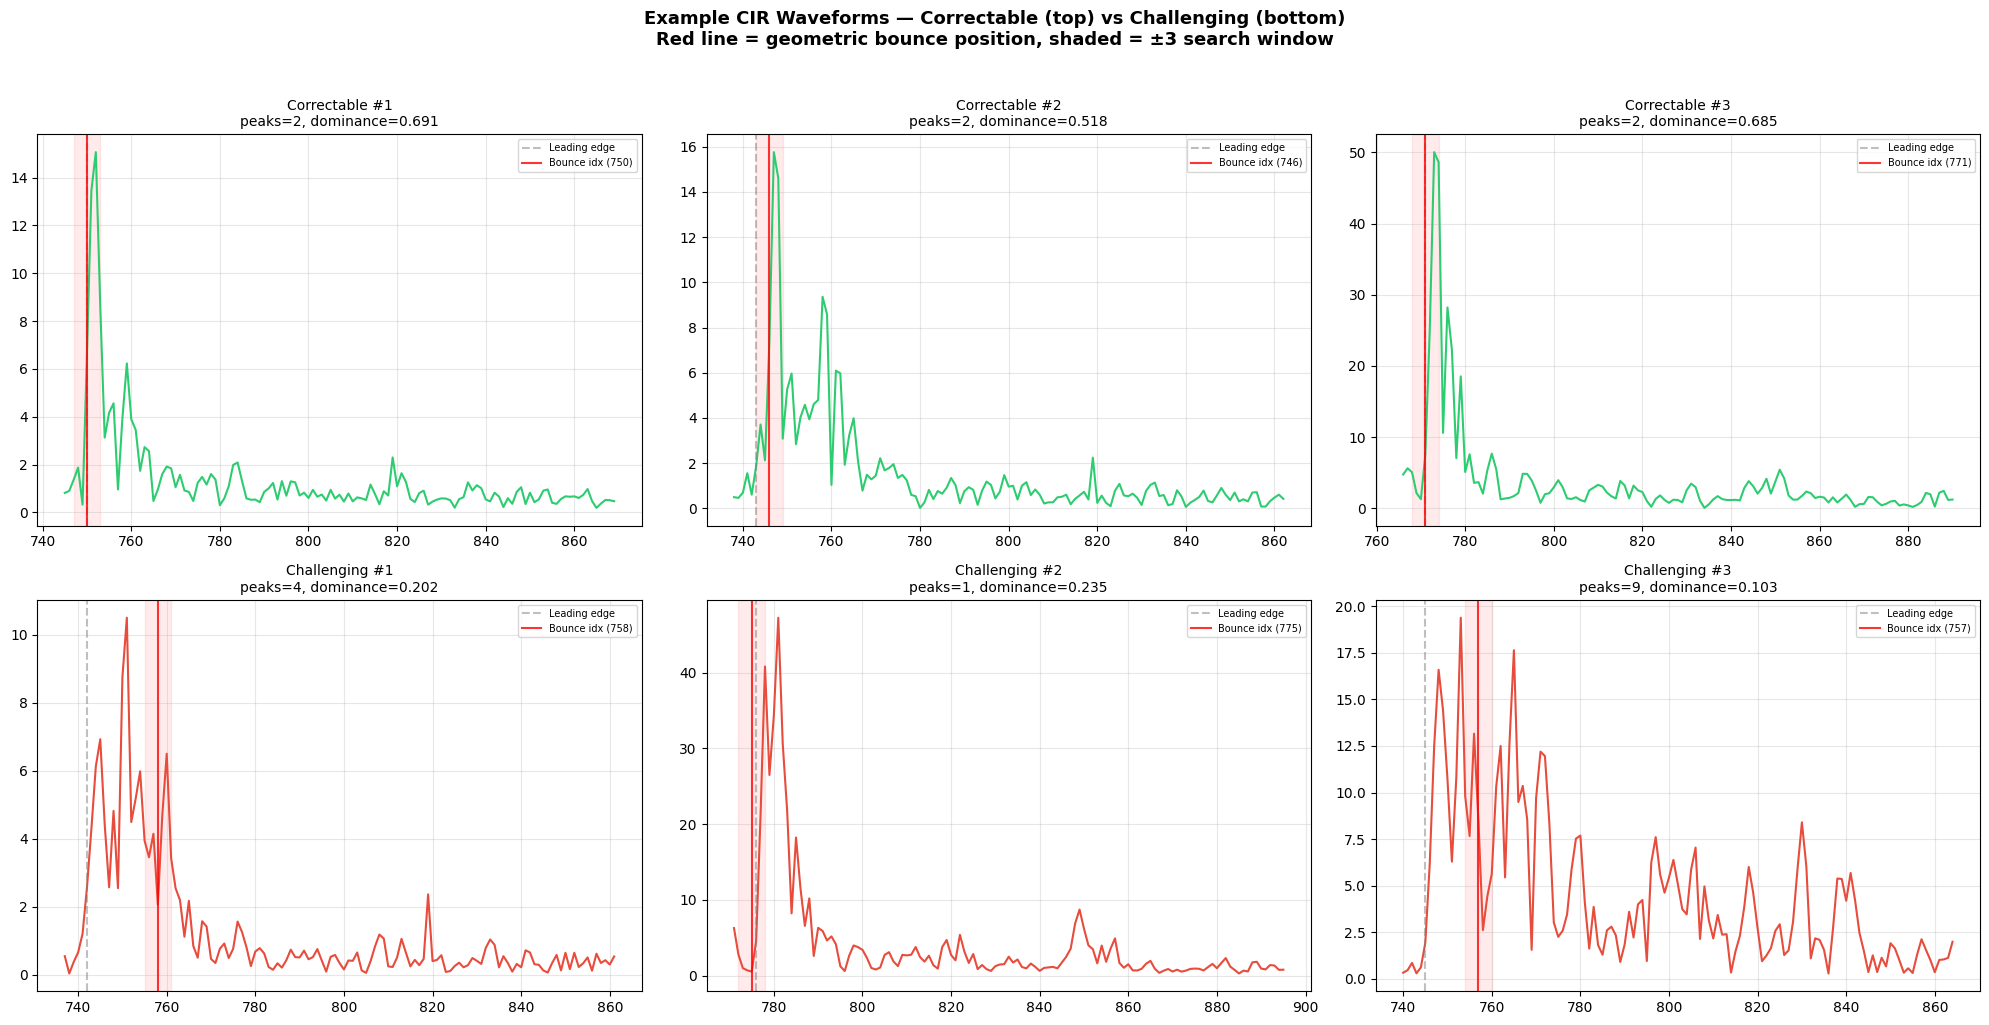

In [84]:
# ==========================================
# EXAMPLE CIR WAVEFORMS (Correctable vs Challenging)
# ==========================================
fig, axs = plt.subplots(2, 3, figsize=(20, 10))
plt.subplots_adjust(hspace=0.45, wspace=0.3)

W = CONFIG['bounce_search_window']
correctable_idx = np.where(quality_labels == 0)[0]
challenging_idx = np.where(quality_labels == 1)[0]

# Show 3 correctable examples (spread across dataset for diversity)
for col in range(3):
    if col >= len(correctable_idx):
        axs[0, col].axis('off')
        continue
    step = max(1, len(correctable_idx) // 3)
    idx = correctable_idx[min(col * step, len(correctable_idx) - 1)]
    sig = raw_sigs[idx]
    le = leading_edges[idx]
    bpi = float(nlos_df.iloc[idx].get('bounce_path_idx', np.nan))
    bounce_idx = int(round(bpi)) if not np.isnan(bpi) else None

    roi_start = max(0, le - 5)
    roi_end = min(len(sig), le + 120)
    x_range = np.arange(roi_start, roi_end)

    ax = axs[0, col]
    ax.plot(x_range, sig[roi_start:roi_end], color='#2ecc71', lw=1.5)
    ax.axvline(le, color='gray', ls='--', alpha=0.5, label='Leading edge')
    if bounce_idx is not None:
        ax.axvline(bounce_idx, color='red', ls='-', lw=1.5, alpha=0.8,
                   label=f'Bounce idx ({bounce_idx})')
        ax.axvspan(max(roi_start, bounce_idx - W), min(roi_end, bounce_idx + W),
                   color='red', alpha=0.08)
    ax.set_title(f"Correctable #{col+1}\n"
                 f"peaks={num_peaks[idx]}, dominance={bounce_dominance[idx]:.3f}",
                 fontsize=10)
    ax.legend(fontsize=7)
    ax.grid(True, alpha=0.3)

# Show 3 challenging examples (spread across dataset)
for col in range(3):
    if col >= len(challenging_idx):
        axs[1, col].axis('off')
        continue
    step = max(1, len(challenging_idx) // 3)
    idx = challenging_idx[min(col * step, len(challenging_idx) - 1)]
    sig = raw_sigs[idx]
    le = leading_edges[idx]
    bpi = float(nlos_df.iloc[idx].get('bounce_path_idx', np.nan))
    bounce_idx = int(round(bpi)) if not np.isnan(bpi) else None

    roi_start = max(0, le - 5)
    roi_end = min(len(sig), le + 120)
    x_range = np.arange(roi_start, roi_end)

    ax = axs[1, col]
    ax.plot(x_range, sig[roi_start:roi_end], color='#e74c3c', lw=1.5)
    ax.axvline(le, color='gray', ls='--', alpha=0.5, label='Leading edge')
    if bounce_idx is not None:
        ax.axvline(bounce_idx, color='red', ls='-', lw=1.5, alpha=0.8,
                   label=f'Bounce idx ({bounce_idx})')
        ax.axvspan(max(roi_start, bounce_idx - W), min(roi_end, bounce_idx + W),
                   color='red', alpha=0.08)
    ax.set_title(f"Challenging #{col+1}\n"
                 f"peaks={num_peaks[idx]}, dominance={bounce_dominance[idx]:.3f}",
                 fontsize=10)
    ax.legend(fontsize=7)
    ax.grid(True, alpha=0.3)

plt.suptitle(f"Example CIR Waveforms — Correctable (top) vs Challenging (bottom)\n"
             f"Red line = geometric bounce position, shaded = ±{W} search window",
             fontsize=13, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

---
## Section 5: Random Forest on LNN Embeddings

**Architecture**: Frozen DualCircuit_PI_HLNN encoder → **64-dim LNN embeddings** → Random Forest Classifier

- **LNN embeddings** (64-dim): Dual-circuit ODE dynamics capture temporal CIR patterns. Attention-pooled, FP_AMPL-conditioned.
- **Random Forest**: Learns to predict signal quality (correctable vs challenging) from temporal embeddings.
- At inference: no peak counting or bounce dominance needed — the RF predicts from embeddings alone.

**Labels**: Mixture of geometric bounce dominance + morphological peak count

In [85]:
# ==========================================
# RANDOM FOREST TRAINING ON LNN EMBEDDINGS (70/30 SPLIT)
# ==========================================
X_all = embeddings  # (1800, 64)
y_all = quality_labels

FEATURE_DIM = X_all.shape[1]

print(f"Input features: {FEATURE_DIM} dimensions (LNN embeddings from frozen Stage 1 DualCircuit_PI_HLNN)")
print(f"Labels: mixture (geometric bounce dominance × morphological peak count)")

# 70/30 stratified split
X_train, X_test, y_train, y_test = train_test_split(
    X_all, y_all,
    test_size=CONFIG["test_ratio"],
    stratify=y_all,
    random_state=CONFIG["seed"]
)

print(f"\nSplit (70/30):")
print(f"  Train: {len(X_train)} (Correctable: {int(np.sum(y_train==0))}, Challenging: {int(np.sum(y_train==1))})")
print(f"  Test:  {len(X_test)} (Correctable: {int(np.sum(y_test==0))}, Challenging: {int(np.sum(y_test==1))})")

# Train Random Forest
rf_model = RandomForestClassifier(
    n_estimators=CONFIG["n_estimators"],
    max_depth=CONFIG["max_depth"],
    min_samples_split=CONFIG["min_samples_split"],
    min_samples_leaf=CONFIG["min_samples_leaf"],
    class_weight="balanced",
    random_state=CONFIG["seed"],
    n_jobs=-1,
)
rf_model.fit(X_train, y_train)

# Evaluate
train_acc = rf_model.score(X_train, y_train)
test_acc = rf_model.score(X_test, y_test)
print(f"\nTrain Accuracy: {100*train_acc:.2f}%")
print(f"Test Accuracy:  {100*test_acc:.2f}%")

Input features: 64 dimensions (LNN embeddings from frozen Stage 1 DualCircuit_PI_HLNN)
Labels: mixture (geometric bounce dominance × morphological peak count)

Split (70/30):
  Train: 1260 (Correctable: 335, Challenging: 925)
  Test:  540 (Correctable: 144, Challenging: 396)

Train Accuracy: 97.14%
Test Accuracy:  91.11%


---
## Section 6: Diagnostics

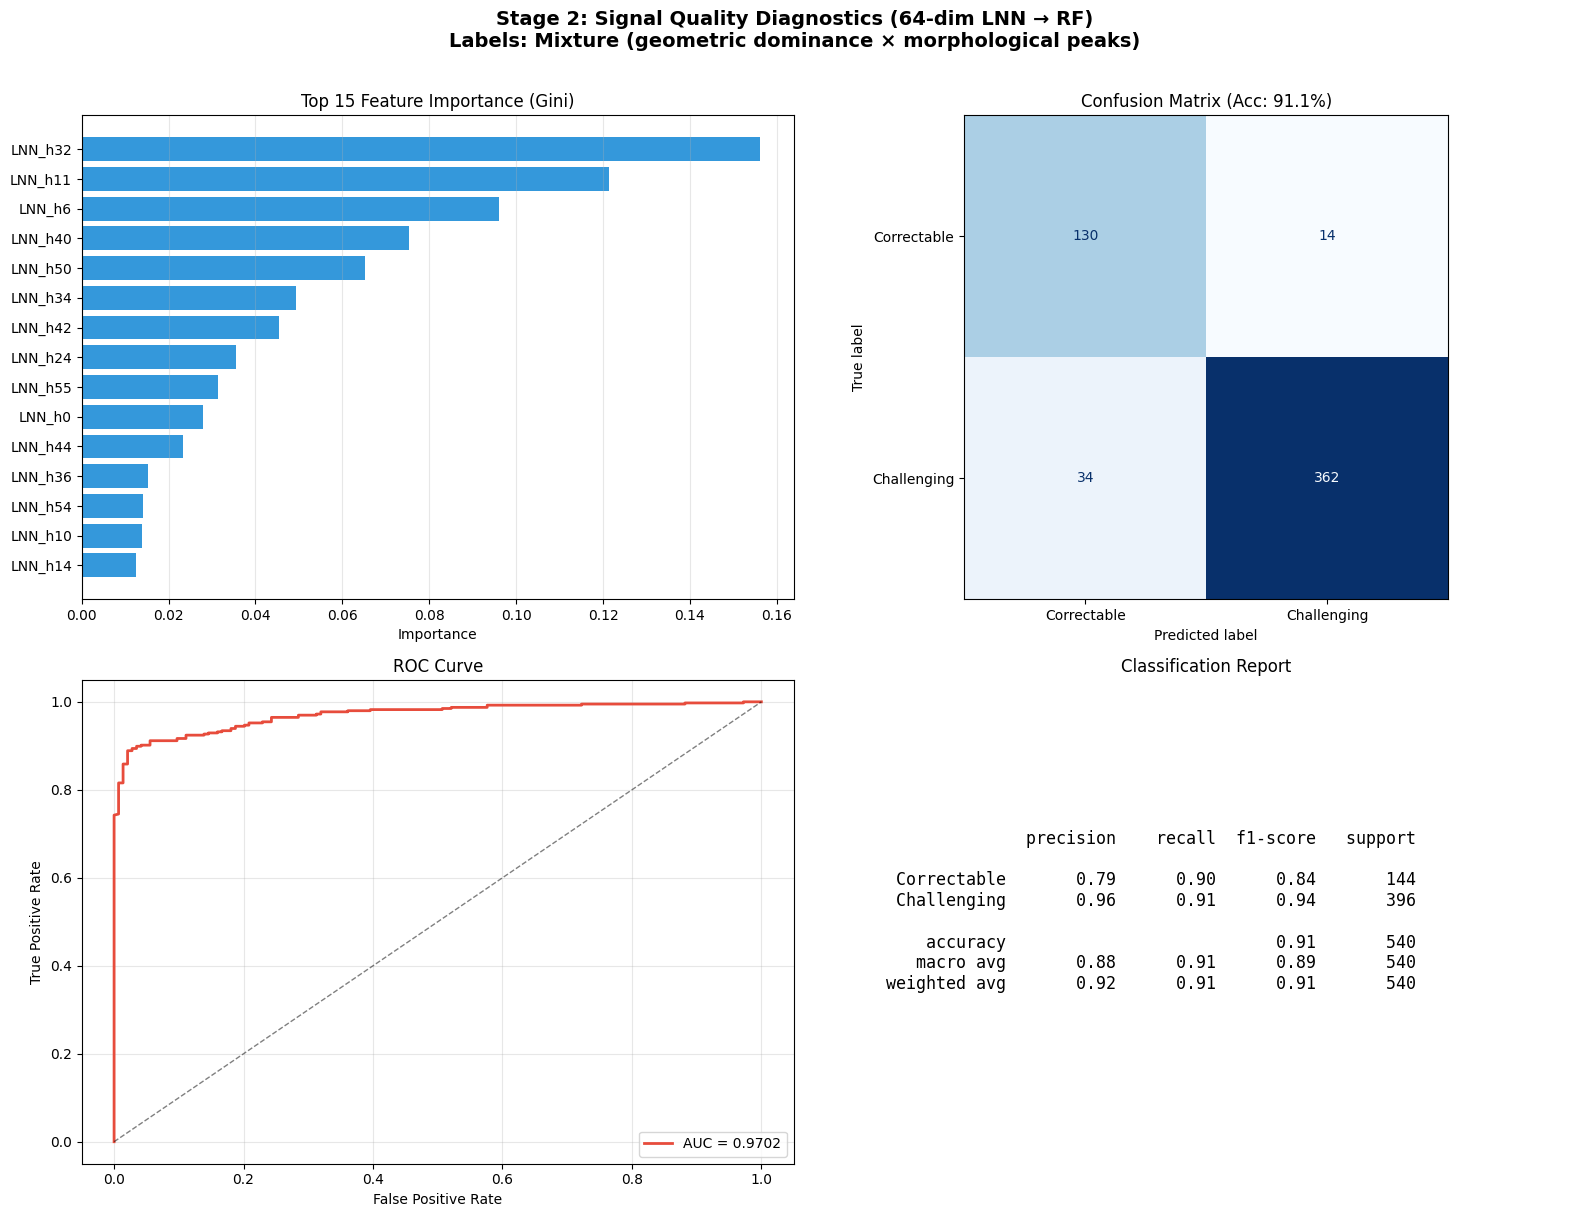


Top 15 Feature Importance (ranked):
  LNN_h32                   0.1561
  LNN_h11                   0.1214
  LNN_h6                    0.0961
  LNN_h40                   0.0753
  LNN_h50                   0.0653
  LNN_h34                   0.0493
  LNN_h42                   0.0453
  LNN_h24                   0.0355
  LNN_h55                   0.0314
  LNN_h0                    0.0280
  LNN_h44                   0.0232
  LNN_h36                   0.0152
  LNN_h54                   0.0142
  LNN_h10                   0.0140
  LNN_h14                   0.0124


In [86]:
# ==========================================
# DIAGNOSTICS
# ==========================================
y_pred = rf_model.predict(X_test)

# Safety: handle single-class edge case
proba = rf_model.predict_proba(X_test)
if proba.shape[1] > 1:
    y_prob = proba[:, 1]
else:
    y_prob = proba[:, 0]

fig, axs = plt.subplots(2, 2, figsize=(16, 12))
plt.subplots_adjust(hspace=0.35, wspace=0.3)

# 1. Feature Importance (top 15 LNN dims)
ax = axs[0, 0]
importances = rf_model.feature_importances_
top_k = min(15, len(importances))
sorted_idx = np.argsort(importances)[-top_k:]
ax.barh(np.array(EMBEDDING_NAMES)[sorted_idx], importances[sorted_idx], color='#3498db')
ax.set_title(f"Top {top_k} Feature Importance (Gini)")
ax.set_xlabel("Importance")
ax.grid(True, alpha=0.3, axis='x')

# 2. Confusion Matrix
ax = axs[0, 1]
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(cm, display_labels=['Correctable', 'Challenging'])
disp.plot(ax=ax, cmap='Blues', colorbar=False)
acc = (y_test == y_pred).mean()
ax.set_title(f"Confusion Matrix (Acc: {100*acc:.1f}%)")

# 3. ROC Curve
ax = axs[1, 0]
if len(np.unique(y_test)) > 1:
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    roc_auc = auc(fpr, tpr)
    ax.plot(fpr, tpr, color='#e74c3c', lw=2, label=f'AUC = {roc_auc:.4f}')
    ax.plot([0, 1], [0, 1], 'k--', lw=1, alpha=0.5)
    ax.set_title("ROC Curve")
    ax.set_xlabel("False Positive Rate")
    ax.set_ylabel("True Positive Rate")
    ax.legend(loc='lower right')
else:
    ax.text(0.5, 0.5, 'Single class in test set', ha='center', va='center', fontsize=12)
    ax.set_title("ROC Curve (N/A)")
ax.grid(True, alpha=0.3)

# 4. Classification Report
ax = axs[1, 1]
report = classification_report(y_test, y_pred,
                               target_names=['Correctable', 'Challenging'])
ax.text(0.05, 0.5, report, fontsize=12, fontfamily='monospace',
        verticalalignment='center', transform=ax.transAxes)
ax.set_title("Classification Report")
ax.axis('off')

plt.suptitle(f"Stage 2: Signal Quality Diagnostics (64-dim LNN → RF)\n"
             f"Labels: Mixture (geometric dominance × morphological peaks)",
             fontsize=14, fontweight='bold', y=1.01)
plt.tight_layout()
plt.show()

# Print top features
print(f"\nTop 15 Feature Importance (ranked):")
for feat, imp in sorted(zip(EMBEDDING_NAMES, importances), key=lambda x: -x[1])[:15]:
    print(f"  {feat:<25} {imp:.4f}")

---
## Section 7: Save Artifacts

In [87]:
# ==========================================
# SAVE ARTIFACTS
# ==========================================
joblib.dump(rf_model, "stage2_bounce_rf.joblib")
print("Saved: stage2_bounce_rf.joblib")

joblib.dump({
    "config": CONFIG,
    "embedding_dim": EMBEDDING_DIM,
    "embedding_names": EMBEDDING_NAMES,
    "feature_dim": FEATURE_DIM,
    "stage1_config": STAGE1_CONFIG,
    "encoder_class": "DualCircuit_PI_HLNN",
    "fp_conditioning": True,
    "label_strategy": "mixture_geometric_morphological",
    "dominance_threshold": CONFIG["dominance_threshold"],
    "bounce_search_window": CONFIG["bounce_search_window"],
    "dominant_path_max_peaks": CONFIG["dominant_path_max_peaks"],
    "note": "Mixture labels: geometric bounce dominance (energy at bounce_path_idx / ROI energy) "
            "AND morphological peak count. Correctable = high dominance AND few peaks. "
            "Model input is 64-dim LNN embeddings. RF predicts signal quality from embeddings alone.",
}, "stage2_config.joblib")
print("Saved: stage2_config.joblib")

print(f"\nDependency: stage1_pi_hlnn_best.pt (frozen DualCircuit_PI_HLNN encoder)")
print(f"Artifacts ready for Stage 3 pipeline.")

Saved: stage2_bounce_rf.joblib
Saved: stage2_config.joblib

Dependency: stage1_pi_hlnn_best.pt (frozen DualCircuit_PI_HLNN encoder)
Artifacts ready for Stage 3 pipeline.


In [88]:
print("=" * 60)
print("Stage 2 — Summary")
print("=" * 60)
print(f"Model artifact: stage2_bounce_rf.joblib")
print(f"Config artifact: stage2_config.joblib")
print(f"Encoder dependency: stage1_pi_hlnn_best.pt (frozen DualCircuit_PI_HLNN)")
print()
print(f"Architecture: Frozen DualCircuit_PI_HLNN encoder → {FEATURE_DIM}-dim LNN embeddings → RF classifier")
print(f"FP_AMPL conditioning: enabled (FP_AMPL1/2/3 seed circuit initial states)")
print()
print(f"Labels: MIXTURE (geometric × morphological)")
print(f"  Geometric:     bounce dominance >= {CONFIG['dominance_threshold']:.0%} (energy at bounce_path_idx / ROI energy)")
print(f"  Morphological: num_peaks <= {CONFIG['dominant_path_max_peaks']}")
print(f"  Combined:      Correctable (0) = BOTH met; Challenging (1) = either fails")
print(f"Test Accuracy: {100*test_acc:.2f}%")
print()
print("Pipeline: Stage 1 (LNN) → Stage 2 (LNN embeddings → RF → signal quality) → Stage 3 (ranging error)")

Stage 2 — Summary
Model artifact: stage2_bounce_rf.joblib
Config artifact: stage2_config.joblib
Encoder dependency: stage1_pi_hlnn_best.pt (frozen DualCircuit_PI_HLNN)

Architecture: Frozen DualCircuit_PI_HLNN encoder → 64-dim LNN embeddings → RF classifier
FP_AMPL conditioning: enabled (FP_AMPL1/2/3 seed circuit initial states)

Labels: MIXTURE (geometric × morphological)
  Geometric:     bounce dominance >= 50% (energy at bounce_path_idx / ROI energy)
  Morphological: num_peaks <= 2
  Combined:      Correctable (0) = BOTH met; Challenging (1) = either fails
Test Accuracy: 91.11%

Pipeline: Stage 1 (LNN) → Stage 2 (LNN embeddings → RF → signal quality) → Stage 3 (ranging error)
